In [2]:
import json
import pandas as pd
import hvplot.pandas
import requests
import numpy as np
from config import openweather_key
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


sales_data_path = "/Users/emelyzelaya/Project1:/Project_1/file.csv"


sales_data = pd.read_csv(sales_data_path)

sales_data.head()


,Unnamed: 0,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,...,Avg_Price,Delivery_Charges,Coupon_Status,GST,Date,Offline_Spend,Online_Spend,Month,Coupon_Code,Discount_pct
0,0,17850.0,M,Chicago,12.0,16679.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
1,1,17850.0,M,Chicago,12.0,16680.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
2,2,17850.0,M,Chicago,12.0,16696.0,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,...,122.77,6.5,Not Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
3,3,17850.0,M,Chicago,12.0,16699.0,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,...,81.50,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
4,4,17850.0,M,Chicago,12.0,16700.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0


In [3]:

#dropping redundant and un-needed columns
sales_data_cleaned = sales_data.drop(['Unnamed: 0', 'Tenure_Months', 'Transaction_Date', 'GST', 'Offline_Spend', 'Online_Spend', 'Month', 'Coupon_Code', 'Discount_pct', 'Product_SKU'], axis=1)


#dropping rows that have incomplete data
sales_data_cleaned = sales_data_cleaned.dropna()


#converting the date to unix time format for the api request & and adding it to a column
sales_data_cleaned['Date'] = pd.to_datetime(sales_data_cleaned['Date'])

sales_data_cleaned["Unix Date"] = sales_data_cleaned['Date'].apply(lambda x: int(x.timestamp()))


sales_data_cleaned.head()

,CustomerID,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Unix Date
0,17850.0,M,Chicago,16679.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Used,2019-01-01,1546300800
1,17850.0,M,Chicago,16680.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Used,2019-01-01,1546300800
2,17850.0,M,Chicago,16696.0,Nest Cam Outdoor Security Camera - USA,Nest-USA,2.0,122.77,6.5,Not Used,2019-01-01,1546300800
3,17850.0,M,Chicago,16699.0,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,1.0,81.50,6.5,Clicked,2019-01-01,1546300800
4,17850.0,M,Chicago,16700.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Clicked,2019-01-01,1546300800


In [4]:
#getting 100 random rows for each city
np.random.seed(42)

def random_rows(group):
    return group.sample(min(len(group), 50))

sales_data_random_cleaned = sales_data_cleaned.groupby('Location', group_keys=False).apply(random_rows)


#hard cording the city coordinates
city_coordinates = {
    "Chicago": (41.8781, -87.6298),
    "California": (36.7783, -119.4179),
    "New Jersey": (40.0583, -74.4057),
    "New York": (40.7128, -74.0060),
    "Washington DC": (38.8951, -77.0364),
}

#adding latitude and longitude columns
sales_data_random_cleaned["Lat"] = sales_data_random_cleaned["Location"].map(city_coordinates).apply(lambda x: x[0])
sales_data_random_cleaned["Lon"] = sales_data_random_cleaned["Location"].map(city_coordinates).apply(lambda x: x[1])


#adding blank weather conditions column
sales_data_random_cleaned["Weather Conditions"] = ""
sales_data_cleaned["Temperature (F)"] = ""

sales_data_random_cleaned.head()

,CustomerID,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Unix Date,Lat,Lon,Weather Conditions
23680,14307.0,F,California,38830.0,Google Stylus Pen w/ LED Light,Office,75.0,4.40,82.48,Clicked,2019-09-23,1569196800,36.7783,-119.4179,
6316,14911.0,F,California,45554.0,Google Youth Baseball Raglan Heather/Black,Apparel,1.0,10.18,6.50,Clicked,2019-12-04,1575417600,36.7783,-119.4179,
44290,17085.0,F,California,31959.0,Leatherette Journal,Office,30.0,8.79,36.06,Clicked,2019-07-06,1562371200,36.7783,-119.4179,
23304,17787.0,M,California,39212.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.00,Not Used,2019-09-27,1569542400,36.7783,-119.4179,
25591,14527.0,M,California,38656.0,Google Tote Bag,Bags,1.0,9.99,6.00,Clicked,2019-09-21,1569024000,36.7783,-119.4179,


In [4]:
#BE CAREFUL RUNNING API REQUEST AS WE ONLY GET 1000 PER DAY
#THIS DATA SET CONTAINS 250 PER RUN!!!
#takes ~2min to run

url = "https://api.openweathermap.org/data/3.0/onecall/timemachine?"
units = "imperial"

print("Starting Weather Search")


#setting the parameters for the api request
for index, row in sales_data_random_cleaned.iterrows():
    latitude = row["Lat"]
    longitude = row["Lon"]
    date = row["Unix Date"]

    params = {
    "lat": latitude,
    "lon": longitude,
    "dt": date,
    "apiKey":openweather_key,
    "units": units
}


    response = requests.get(url, params=params)

    response = response.json()

  
 #getting the weather description for each row and putting it in the weather conditions column
 #add temperature column
    try:
        sales_data_random_cleaned.loc[index, "Weather Conditions"] = response["data"][0]["weather"][0]["description"]
        sales_data_random_cleaned.loc[index, "Temperature (F)"] = response["data"][0]["temp"]
        print(f"Weather Search Complete for {sales_data_random_cleaned.at[index, 'Date']}, in {sales_data_random_cleaned.at[index, 'Location']}")

    except KeyError as e:
        print("No Weather Data Found")


    

sales_data_random_cleaned.head(25)


Starting Weather Search
Weather Search Complete for 2019-09-23 00:00:00, in California
Weather Search Complete for 2019-12-04 00:00:00, in California
Weather Search Complete for 2019-07-06 00:00:00, in California
Weather Search Complete for 2019-09-27 00:00:00, in California
Weather Search Complete for 2019-09-21 00:00:00, in California
Weather Search Complete for 2019-02-28 00:00:00, in California
Weather Search Complete for 2019-08-23 00:00:00, in California
Weather Search Complete for 2019-09-15 00:00:00, in California
Weather Search Complete for 2019-10-12 00:00:00, in California
Weather Search Complete for 2019-04-30 00:00:00, in California
Weather Search Complete for 2019-06-05 00:00:00, in California
Weather Search Complete for 2019-12-15 00:00:00, in California
Weather Search Complete for 2019-11-30 00:00:00, in California
Weather Search Complete for 2019-04-06 00:00:00, in California
Weather Search Complete for 2019-08-22 00:00:00, in California
Weather Search Complete for 201

,CustomerID,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Unix Date,Lat,Lon,Weather Conditions,Temperature (F)
23680,14307.0,F,California,38830.0,Google Stylus Pen w/ LED Light,Office,75.0,4.40,82.48,Clicked,2019-09-23,1569196800,36.7783,-119.4179,clear sky,89.82
6316,14911.0,F,California,45554.0,Google Youth Baseball Raglan Heather/Black,Apparel,1.0,10.18,6.50,Clicked,2019-12-04,1575417600,36.7783,-119.4179,mist,55.81
44290,17085.0,F,California,31959.0,Leatherette Journal,Office,30.0,8.79,36.06,Clicked,2019-07-06,1562371200,36.7783,-119.4179,clear sky,95.90
23304,17787.0,M,California,39212.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.00,Not Used,2019-09-27,1569542400,36.7783,-119.4179,clear sky,93.34
25591,14527.0,M,California,38656.0,Google Tote Bag,Bags,1.0,9.99,6.00,Clicked,2019-09-21,1569024000,36.7783,-119.4179,clear sky,81.27
32296,15889.0,F,California,21567.0,Ballpoint LED Light Pen,Office,30.0,2.50,6.50,Used,2019-02-28,1551312000,36.7783,-119.4179,broken clouds,63.05
11220,17841.0,M,California,36378.0,Android Onesie Gold,Apparel,1.0,19.19,6.00,Clicked,2019-08-23,1566518400,36.7783,-119.4179,scattered clouds,95.31
24126,16814.0,M,California,38257.0,Google Women's Long Sleeve Tee Lavender,Apparel,1.0,9.60,6.00,Used,2019-09-15,1568505600,36.7783,-119.4179,clear sky,98.62
48148,13819.0,F,California,40567.0,Nest Cam Outdoor Security Camera - USA,Nest-USA,1.0,199.00,6.00,Clicked,2019-10-12,1570838400,36.7783,-119.4179,clear sky,78.64
37038,16727.0,F,California,26830.0,Google Women's Long Sleeve Tee Lavender,Apparel,1.0,23.99,12.99,Clicked,2019-04-30,1556582400,36.7783,-119.4179,clear sky,75.58


In [5]:
sales_data_final = sales_data_random_cleaned.drop(['Lat', 'Lon', 'Unix Date'], axis=1)


sales_data_final

,CustomerID,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Weather Conditions
23680,14307.0,F,California,38830.0,Google Stylus Pen w/ LED Light,Office,75.0,4.40,82.48,Clicked,2019-09-23,
6316,14911.0,F,California,45554.0,Google Youth Baseball Raglan Heather/Black,Apparel,1.0,10.18,6.50,Clicked,2019-12-04,
44290,17085.0,F,California,31959.0,Leatherette Journal,Office,30.0,8.79,36.06,Clicked,2019-07-06,
23304,17787.0,M,California,39212.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.00,Not Used,2019-09-27,
25591,14527.0,M,California,38656.0,Google Tote Bag,Bags,1.0,9.99,6.00,Clicked,2019-09-21,
...,...,...,...,...,...,...,...,...,...,...,...,...
17953,18055.0,F,Washington DC,23328.0,26 oz Double Wall Insulated Bottle,Drinkware,2.0,19.99,6.50,Clicked,2019-03-19,
32098,17796.0,F,Washington DC,20601.0,Google Doodle Decal,Office,1.0,2.99,6.50,Clicked,2019-02-16,
34305,15723.0,F,Washington DC,26471.0,Nest Cam Indoor Security Camera - USA,Nest-USA,1.0,119.00,6.00,Used,2019-04-26,
2429,17976.0,M,Washington DC,18700.0,Google Women's Fleece Hoodie,Apparel,1.0,57.76,6.50,Used,2019-01-24,


In [ ]:
###How does inclement weather affect shopping habits?
## compare if the volume of shopping increased during inclement weather (light rain, moderate rain, heavy rain, mist, overcast?) and good weather (clear sky, scattered clouds, etc.)
## scatter plot & lin regress & bar graph maybe


#sergio


In [ ]:
#how do extreme temps affect online shopping habits
# compare if temperatures affect online shopping habits (scatter plot & lin regress)

##larry


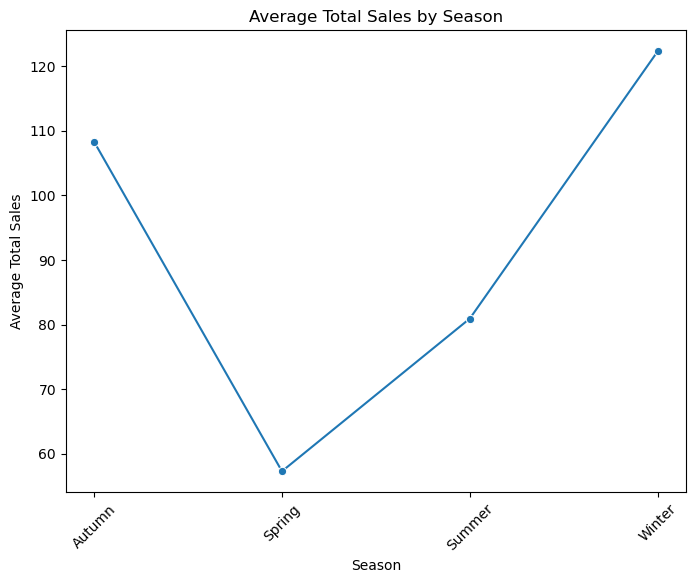

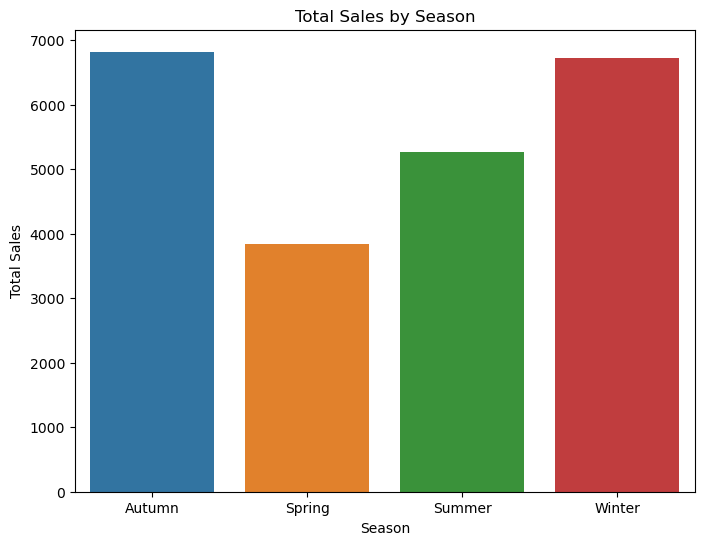

In [6]:
#how does season affect online shopping habits

#Spring: March 1st - May 31st
#Summer: June 1st - August 31st
#Autumn (Fall): September 1st - November 30th
#Winter: December 1st - February 28th


# Convert 'Date' to datetime and create 'Season' column
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:  # months 12, 1, 2
        return 'Winter'

sales_data_final['Date'] = pd.to_datetime(sales_data_final['Date'])
sales_data_final['Season'] = sales_data_final['Date'].dt.month.apply(get_season)

# Calculating Total Sales (Quantity * Avg_Price)
sales_data_final['Total_Sales'] = sales_data_final['Quantity'] * sales_data_final['Avg_Price']

# Aggregating data by season for the line plot
seasonal_sales_line = sales_data_final.groupby('Season').agg({'Total_Sales':'mean'}).reset_index()

# Creating the line plot for seasonal sales
plt.figure(figsize=(8, 6))
sns.lineplot(x='Season', y='Total_Sales', data=seasonal_sales_line, marker='o')
plt.title('Average Total Sales by Season')
plt.xlabel('Season')
plt.ylabel('Average Total Sales')
plt.xticks(rotation=45)
plt.show()

# Aggregating data by season for the bar plot
seasonal_sales_bar = sales_data_final.groupby('Season')['Total_Sales'].sum().reset_index()

# Creating the bar plot for total sales by season
plt.figure(figsize=(8, 6))
sns.barplot(x='Season', y='Total_Sales', data=seasonal_sales_bar)
plt.title('Total Sales by Season')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.show()

#Emely

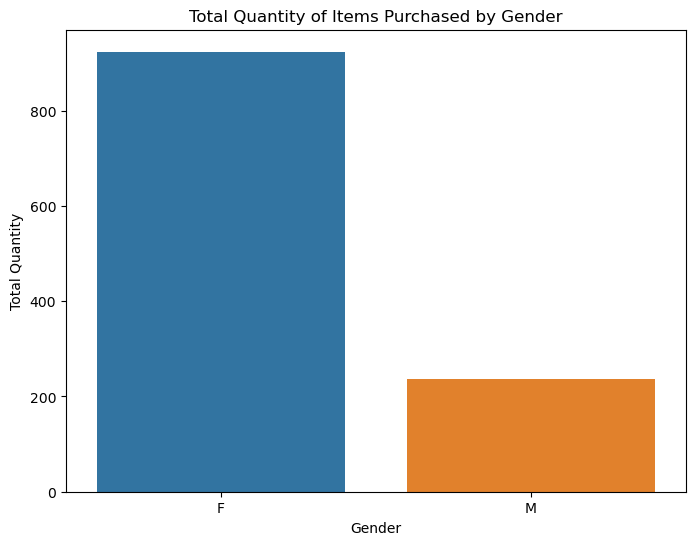

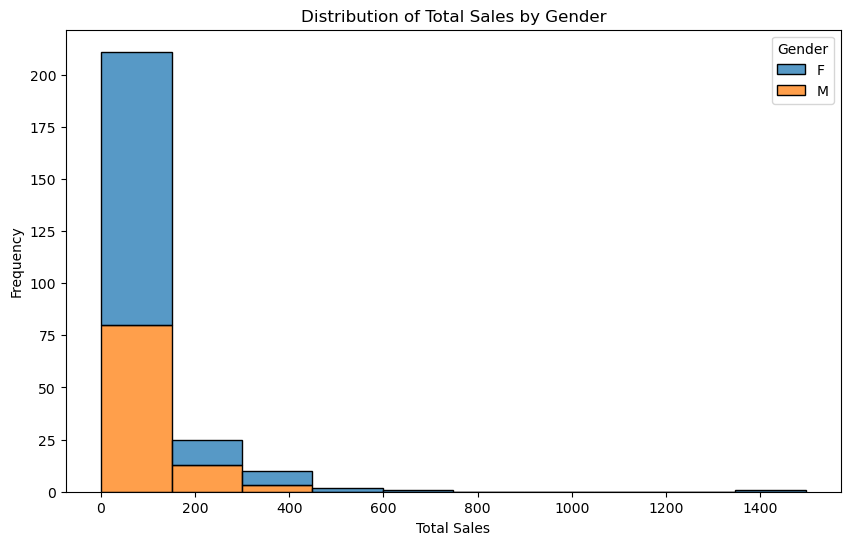

In [7]:
#how does gender impact online shopping habits

# Calculating Total Sales (Quantity * Avg_Price)
sales_data_final['Total_Sales'] = sales_data_final['Quantity'] * sales_data_final['Avg_Price']

# Bar Plot: Total Quantity of Items Purchased by Gender
plt.figure(figsize=(8, 6))
total_quantity_by_gender = sales_data_final.groupby('Gender')['Quantity'].sum().reset_index()
sns.barplot(x='Gender', y='Quantity', data=total_quantity_by_gender)
plt.title('Total Quantity of Items Purchased by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Quantity')
plt.show()

# Histogram: Distribution of Total Sales by Gender
plt.figure(figsize=(10, 6))
sns.histplot(data=sales_data_final, x='Total_Sales', hue='Gender', multiple='stack', bins=10)
plt.title('Distribution of Total Sales by Gender')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.show()


#Emely

In [ ]:
#does the availability of discounts or promotions influence online shopping behavior on online shopping habits  

#rebecca

In [ ]:
#are promotions or discounts used more often during inclement weather

#rebecca

In [ ]:
#is there a correlation between the peak shopping season and the occurrence of the most extreme temperatures within a given geographical region

#Larry

In [ ]:
#does the severity of weather influence online shopping behavior?

#Sergio

In [12]:
#is there a correlation between inclement weather and product category?

weather_and_category_df = pd.get_dummies(sales_data_final[['Weather Conditions', 'Product_Category']])

contingency_table = pd.crosstab(sales_data_final['Weather Conditions'], sales_data_final['Product_Category'])

chi2, p, _, _ = stats.chi2_contingency(contingency_table)



print(f"Chi-Squared {chi2}")
print(f"P-Value {p}")


#matt

Chi-Squared 147.95598673383
P-Value 0.3710564770446312



Null Hypothesis:
There is no relation between weather conditions and the ordering of a specific product category

The p-value is greater than a significance level of 0.05, therefore we reject the null hypothesis.



In [13]:
#descriptive statistics of weather and product category


descriptive_stats = sales_data_final.groupby('Weather Conditions')['Product_Category'].describe()

print(descriptive_stats)




                     count unique       top freq
Weather Conditions                              
broken clouds           32      8   Apparel   10
clear sky               86     10   Apparel   32
few clouds              20      7   Apparel    9
heavy intensity rain     1      1      Nest    1
light rain              32      8   Apparel   11
light snow               1      1  Nest-USA    1
mist                     8      4   Apparel    3
moderate rain           14      6   Apparel    6
overcast clouds         33      9   Apparel   12
scattered clouds        19      6   Apparel    8
thunderstorm             2      2   Apparel    1
very heavy rain          2      2  Headgear    1


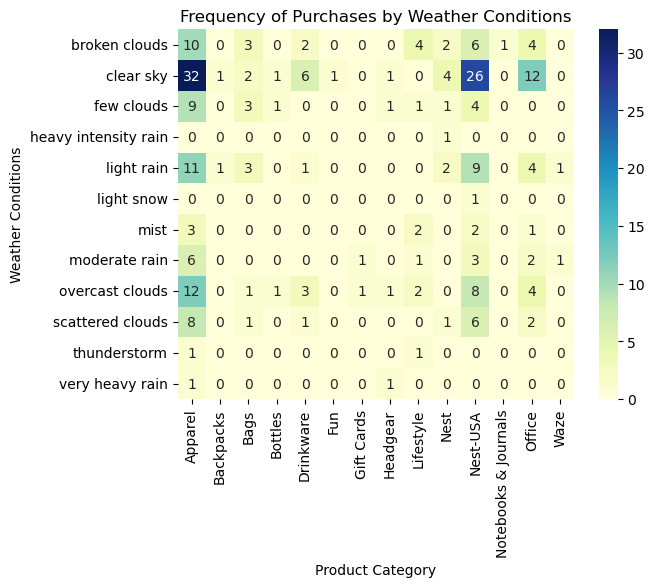

In [21]:
contingency_table = pd.crosstab(sales_data_final['Weather Conditions'], sales_data_final['Product_Category'])
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')

plt.title('Frequency of Purchases by Weather Conditions')
plt.xlabel('Product Category')
plt.ylabel('Weather Conditions')

plt.show()

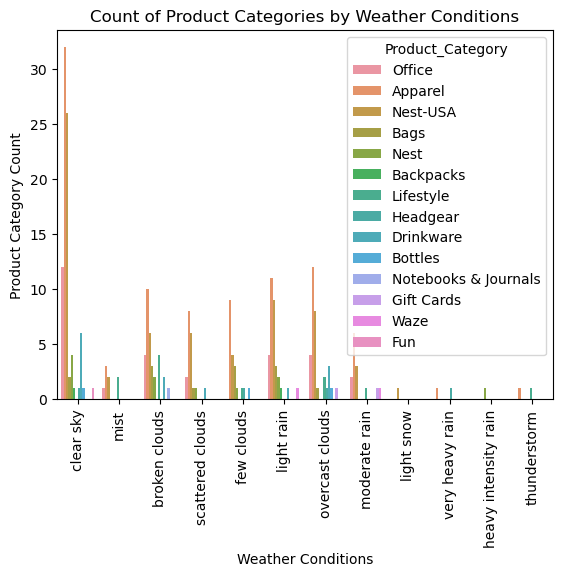

In [18]:
#adding bar chart

sns.countplot(x='Weather Conditions', hue='Product_Category', data=sales_data_final)

plt.xticks(rotation=90)
plt.xlabel('Weather Conditions')
plt.ylabel('Product Category Count')
plt.title('Count of Product Categories by Weather Conditions')

plt.show()

